<a href="https://colab.research.google.com/github/cpyp-ipdp/pgd_cdmx/blob/main/indicadores/pueblos_indigenas/indicadores_pueblos_indigenas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##Estimación de indicadores de población indígena en la Ciudad de México
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr, haven, googledrive)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)

Loading required package: pacman





── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpBNU7NZ/remotes13d2e35df8f/cpyp-ipdp-funcionespgd-8b2a39e/DESCRIPTION’ ... OK
* preparing ‘funcionespgd’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘funcionespgd_0.1.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
#Fuente para los gráficos
font_add_google("Poppins", "pop")
showtext_auto()

In [4]:
#Crear directorio para guardar los archivos
dir.create("data", showWarnings = FALSE)

In [5]:
url_basica<-"https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte<-"microdatos/enigh"
fin1<-"_ns_"
fin2<-"_csv.zip"

In [6]:
years<-c("2016", "2018", "2020", "2022")

In [7]:
# Función genérica para descargar, descomprimir, renombrar y eliminar
procesar_archivo <- function(year, tipo, url_base, segunda_parte, fin1, fin2, carpeta_destino) {
  # Construir URL y ruta de destino
  url <- paste0(url_base, year, "/", segunda_parte, year, fin1, tipo, fin2)
  destfile <- paste0(carpeta_destino, "/", year, fin1, tipo, fin2)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = carpeta_destino)

  # Renombrar el archivo descomprimido
  file.rename(
    from = paste0(carpeta_destino, "/", tipo, ".csv"),
    to = paste0(carpeta_destino, "/", tipo, "_", year, ".csv")
  )

  # Eliminar el archivo descargado
  file.remove(destfile)
}

In [8]:
# Iterar sobre los años y procesar cada tipo de archivo

for (i in 1:length(years)) {
  procesar_archivo(years[i], "poblacion", url_basica, segunda_parte, fin1, fin2, "data")
  procesar_archivo(years[i], "viviendas", url_basica, segunda_parte, fin1, fin2, "data")
  procesar_archivo(years[i], "trabajos", url_basica, segunda_parte, fin1, fin2, "data")
}

### Función de estimación

In [9]:
estimacion <- function(path, variable) {
  # Cargar los datos de población
  datos <- read_csv(path, show_col_types = FALSE)

  # Si son datos de 2016 a 2020, unir con la tabla de viviendas
  if (substr(path, 16, 19) %in% c("2016", "2018", "2020")) {
    # Cargar tabla viviendas
    vivienda <- read_csv(str_replace(path, "poblacion", "viviendas"), show_col_types = FALSE)

    # Pegar factor, upm y est_dis de la tabla vivienda
    datos <- datos %>%
      left_join(vivienda %>% select(folioviv, factor, upm, est_dis), by = "folioviv")
  }

  # Unir con la tabla trabajos si es "ocupacion" o si la persona debe ser identificada como indígena
  if (variable %in% c("ocupacion", "ocupacion_mujer")) {
    # Cargar tabla trabajos
    trabajos <- read_csv(str_replace(path, "poblacion", "trabajos"), show_col_types = FALSE)

    # Pegar datos relevantes de la tabla trabajos
    datos <- datos %>%
      left_join(trabajos %>% select(folioviv, foliohog, numren, id_trabajo, trapais),
                by = c("folioviv", "foliohog", "numren"))
  }

  # Crear variable cve_ent
  datos <- datos %>%
    mutate(cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    )) %>%
    # Filtrar si entidad es CDMX (09)
    filter(cve_ent == "09")

  # Definir diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)

  # Estimar población hablante indígena en CDMX
  if (variable == "hablante") {
    hablante <- mydesign %>%
      group_by(hablaind) %>%
      summarise(
        poblacion = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
      filter(hablaind == 1)

    return(hablante)
  }

    # Estimar población hablante indígena en CDMX
  if (variable == "indigena") {
    indigena <- mydesign %>%
      group_by(etnia) %>%
      summarise(
        poblacion = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
      filter(etnia == 1)

    return(indigena)
  }


  # Estimar población ocupada, considerando si la persona es indígena
  if (variable == "ocupacion") {
    ocupacion <- mydesign %>%
      group_by(trapais,etnia) %>%
      summarise(
        ocupados = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
      filter(trapais == 1)%>%
filter(etnia == 1)
    return(ocupacion)
  }



  # Estimar población ocupada, considerando si la persona es indígena
  if (variable == "ocupacion_mujer") {
    ocupacion_muj <- mydesign %>%
      filter(trapais==1)%>%
      group_by(etnia,sexo) %>%
      summarise(
        ocupados = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
        #Filtro población indígena
filter(etnia == 1) %>%
  #Filtro mujer
filter(sexo==2)
    return(ocupacion_muj)
  }





  # Estimar población analfabeta
  if (variable == "analfabetismo") {
    analfa <- mydesign %>%
      group_by(etnia,alfabetism) %>%
      summarise(
        analfabetas = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
filter(etnia == 1)%>%
filter(alfabetism == 2)
    return(analfa)
  }

}


#### Población hablante indígena en CDMX

In [10]:
tabla_hablante<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "hablante"
)
print("Población hablante de lengua indígena en la CDMX")
tabla_hablante

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


[1] "Población hablante de lengua indígena en la CDMX"


hablaind,poblacion,poblacion_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,129097,0.1508605,1.41,0.1505873,2016
1,127656,0.2158292,1.38,0.2139413,2018
1,154656,0.1536397,1.67,0.1530732,2020
1,134098,0.1518493,1.43,0.1521503,2022


#### Población autodescripción indígena en CDMX

In [11]:
tabla_indigena<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "indigena"
)
print("Porcentaje de población que se autodescribe como indígena en la CDMX")
tabla_indigena

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


[1] "Porcentaje de población que se autodescribe como indígena en la CDMX"


etnia,poblacion,poblacion_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1250855,0.08416010,13.65,0.08129632,2016
1,1368626,0.08241738,14.85,0.07840943,2018
1,1392732,0.06554796,15.04,0.06381047,2020
1,1103900,0.07699844,11.81,0.07609140,2022


#### Población ocupada indígena en CDMX

In [12]:
tabla_ocupacion<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "ocupacion"
)
print("Población que se autodescribe como indígena y que se encuentra ocupada en la CDMX")
tabla_ocupacion

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or mo

[1] "Población que se autodescribe como indígena y que se encuentra ocupada en la CDMX"


trapais,etnia,ocupados,ocupados_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,701096,0.08687768,15.24,0.08163274,2016
1,1,716466,0.08822712,15.83,0.08266348,2018
1,1,684724,0.06773705,16.27,0.06419507,2020
1,1,550736,0.08300888,11.86,0.08205935,2022


####   Población ocupada indígena mujer en CDMX

In [13]:
tabla_ocupacion_mujer<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "ocupacion_mujer"
)
print("Población que se autodescribe como indígena que es mujer y que se encuentra ocupada en la CDMX")
tabla_ocupacion_mujer

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or mo

[1] "Población que se autodescribe como indígena que es mujer y que se encuentra ocupada en la CDMX"


etnia,sexo,ocupados,ocupados_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2,308308,0.10074117,43.98,0.04794138,2016
1,2,321598,0.10590241,44.89,0.04630140,2018
1,2,311122,0.07667507,45.44,0.04340553,2020
1,2,229755,0.09928867,41.72,0.05397506,2022


####   Población analfabeta indígena en CDMX

In [14]:
tabla_analfabetismo<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "analfabetismo"
)
print("Población que se autodescribe como indígena y que es analfabeta en la CDMX")

tabla_analfabetismo

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“There was 1 warning in `dplyr::summarise()`.
ℹ In argument: `porcentaje = survey_prop(vartype = "cv")`.
ℹ In group 5: `etnia = NA` `alfabetism = NA`.
Caused by warning:
! glm.fit: algorithm did not converge”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“There was 1 warning in `dplyr::summarise()`.
ℹ In argument: `porcentaje = survey_prop(vartype = "cv")`.
ℹ In group 5: `etnia = NA` `alfabetism = NA`.
Caused by warning:
! glm.fit: algorithm did not co

[1] "Población que se autodescribe como indígena y que es analfabeta en la CDMX"


etnia,alfabetism,analfabetas,analfabetas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2,76848,0.2047636,6.14,0.1804278,2016
1,2,100372,0.1583444,7.33,0.1251706,2018
1,2,91929,0.1348095,6.60,0.1153417,2020
1,2,63920,0.2065419,5.79,0.1828260,2022


### Calcular porcentaje de población indígena que se encuentra en situación de pobreza


Para esto, se utilizan las bases generadas por Evalúa CDMX. Es importante señalar que, por practicidad, se trabaja con el producto terminado, no obstante, se buscará en próximas fechas replicar dicha metodología utilizando R ya que actualmente, el programa de cálculo se encuentra en STATA.

In [15]:
  #Conectar a google drive
drive_auth(email = "cpyp.ipdp@gmail.com",cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=9f22bdca62a080937e1b65e797e95c12&login_hint=cpyp.ipdp%40gmail.com&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVVKUi14NDd5SUkyX3FodDJPUnN5eE5ZbHliTWRCemo0VFJCSEJqSkZZOGtObTNpSWE4TnVQVjJ4dkpERjROaFlpd3F1USIsInN0YXRlIjoiOWYyMmJkY2E2MmEwODA5MzdlMWI2NWU3OTdlOTVjMTIifQ==


In [16]:
carpeta<-as_id(drive_get("https://drive.google.com/drive/folders/1TBfoik4w4DWhwFqWeZFgkZvrBdDbqzku"))


archivos<-drive_ls(carpeta)
print(archivos)

# A dribble: 3 × 3
  name             id                                drive_resource   
  <chr>            <drv_id>                          <list>           
1 pobreza_2022.dta 1T_WfYanYMOoWWbhj_CeiqxYRNrpXmDan <named list [41]>
2 pobreza_2018.dta 1TTRfiRDGWgQwHylvduHx1IRdm5vQ3VeL <named list [41]>
3 pobreza_2020.dta 1TXJLNA_itWfjsGIdoj1bJQ4erNjc1wIx <named list [41]>


In [17]:
archivos[1]

name
<chr>
pobreza_2022.dta
pobreza_2018.dta
pobreza_2020.dta


In [18]:
estimacion_pobreza <- function(file_id, file_name) {
  # Descarga de datos
  local_path <- file.path("data", file_name)
  drive_download(as_id(file_id), path = local_path, overwrite = TRUE)

  # Leer datos
  datos <- read_dta(local_path)

  # Añadir año
  year <- str_extract(file_name, "\\d{4}")


  # Diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)

  # Estima pobreza
  pobreza <- mydesign %>%
    #Filtrar datos para CDMX
  filter(entidad==9)%>%
    #Filtar grupo de población en pobreza
    #filter(pobreza_mmip == 1) %>%
    group_by(etnia,pobreza_mmip)%>%
    summarise(
      poblacion = survey_total(vartype = "cv"),
      porcentaje = survey_prop(vartype = "cv")
    ) %>%
    mutate(porcentaje = round(porcentaje * 100, 2),
           year = as.numeric(year))%>%
             #Filtro de población indígena
             filter(etnia==1)

  return(pobreza)
}


In [19]:
estimacion_pobreza_simple <- function(file_id, file_name) {
  # Descarga de datos
  local_path <- file.path("data", file_name)
  drive_download(as_id(file_id), path = local_path, overwrite = TRUE)

  # Leer datos
  datos <- read_dta(local_path)

  # Añadir año
  year <- str_extract(file_name, "\\d{4}") %>% as.numeric()

  # Filtrar datos para CDMX y población en pobreza
  pobreza <- datos %>%
    filter(entidad == 9) %>%
    group_by(etnia,pobreza_mmip) %>%
    summarise(
      observaciones = n(),  # Contar el número de observaciones
      porcentaje = (n() / nrow(datos)) * 100  # Calcular porcentaje sobre el total de la tabla
    ) %>%
    mutate(
      porcentaje = round(porcentaje, 2),
      year = year
    ) %>%
    # Filtro de población indígena
    filter(etnia == 1)%>%
      select(pobreza_mmip,observaciones,year)

  return(pobreza)
}


In [20]:
tabla_pobreza <- map_dfr(
  seq_len(nrow(archivos)),
  ~ estimacion_pobreza(archivos$id[.x], archivos$name[.x])
)%>%
  arrange(year)%>%
  filter(pobreza_mmip==1)

print("Estimación de población indígena en situación de pobreza en la CDMX")
tabla_pobreza

File downloaded:

• pobreza_2022.dta <id: 1T_WfYanYMOoWWbhj_CeiqxYRNrpXmDan>

Saved locally as:

• data/pobreza_2022.dta

File downloaded:

• pobreza_2018.dta <id: 1TTRfiRDGWgQwHylvduHx1IRdm5vQ3VeL>

Saved locally as:

• data/pobreza_2018.dta

File downloaded:

• pobreza_2020.dta <id: 1TXJLNA_itWfjsGIdoj1bJQ4erNjc1wIx>

Saved locally as:

• data/pobreza_2020.dta



[1] "Estimación de población indígena en situación de pobreza en la CDMX"


etnia,pobreza_mmip,poblacion,poblacion_cv,porcentaje,porcentaje_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1011897,0.09435402,74.41,0.03664584,2018
1,1,921413,0.07989246,66.35,0.03980687,2020
1,1,816899,0.08744365,75.13,0.03089138,2022


In [21]:
tabla_pobreza_simple <- map_dfr(
  seq_len(nrow(archivos)),
  ~ estimacion_pobreza_simple(archivos$id[.x], archivos$name[.x])
)%>%
  arrange(year)%>%
  select(pobreza_mmip,observaciones,year)

print("Observaciones muestrales de población indígena y condición de pobreza en la CDMX")
tabla_pobreza_simple

File downloaded:

• pobreza_2022.dta <id: 1T_WfYanYMOoWWbhj_CeiqxYRNrpXmDan>

Saved locally as:

• data/pobreza_2022.dta

`summarise()` has grouped output by 'etnia'. You can override using the
`.groups` argument.
Adding missing grouping variables: `etnia`
File downloaded:

• pobreza_2018.dta <id: 1TTRfiRDGWgQwHylvduHx1IRdm5vQ3VeL>

Saved locally as:

• data/pobreza_2018.dta

`summarise()` has grouped output by 'etnia'. You can override using the
`.groups` argument.
Adding missing grouping variables: `etnia`
File downloaded:

• pobreza_2020.dta <id: 1TXJLNA_itWfjsGIdoj1bJQ4erNjc1wIx>

Saved locally as:

• data/pobreza_2020.dta

`summarise()` has grouped output by 'etnia'. You can override using the
`.groups` argument.
Adding missing grouping variables: `etnia`
Adding missing grouping variables: `etnia`


[1] "Observaciones muestrales de población indígena y condición de pobreza en la CDMX"


etnia,pobreza_mmip,observaciones,year
<chr>,<dbl>,<int>,<dbl>
1,0,253,2018
1,1,1064,2018
1,0,388,2020
1,1,1359,2020
1,0,235,2022
1,1,1019,2022


### Estimación de metas de indicadores propuestos

*Porcentaje de población analfabeta indígena en la CDMX*

In [22]:
#Tabla de analfabetismo
datos<-data.frame(tabla_analfabetismo$year,tabla_analfabetismo$porcentaje)%>%
    rename(year=tabla_analfabetismo.year,
             porcentaje=tabla_analfabetismo.porcentaje)%>%
mutate(year=as.numeric(year))
datos

year,porcentaje
<dbl>,<dbl>
2016,6.14
2018,7.33
2020,6.60
2022,5.79


In [23]:
##Calcular tasa de crecimiento promedio anual de 2016 a 2022

valor_inicial<-datos$porcentaje[1]
valor_final <- datos$porcentaje[length(datos$porcentaje)]
n <- datos$year[length(datos$year)] - datos$year[1]

tasa_crecimiento <- (valor_final / valor_inicial)^(1 / n) - 1
print("Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025")
tasa_crecimiento

[1] "Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025"


[1] -0.009734386

In [24]:
proyecciones <- data.frame(year = seq(2023, 2045, by = 1))
proyecciones$porcentaje <- valor_final * (1 + tasa_crecimiento)^(proyecciones$year - 2022)
proyecciones

year,porcentaje
<dbl>,<dbl>
2023,5.733638
2024,5.677824
2025,5.622554
2026,5.567822
2027,5.513623
2028,5.459951
2029,5.406802
2030,5.354170
2031,5.302050


In [25]:
datos_proyectados <- rbind(datos, proyecciones)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


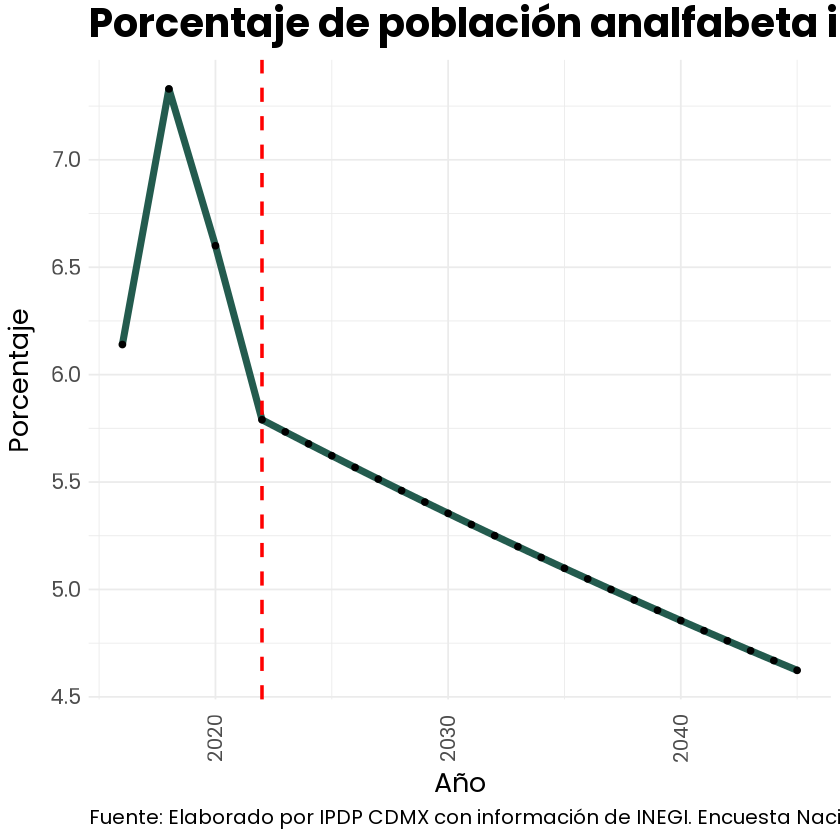

In [26]:
#Gráfica
ggplot(datos_proyectados, aes(x = year, y = porcentaje)) +
  geom_line(color="#235B4E", size=2)+
  geom_point() +
  geom_vline(xintercept = 2022, linetype = "dashed", color = "red", size = 1)+
  labs(title = "Porcentaje de población analfabeta indígena en la CDMX, 2016-2045",
       x = "Año",
       y = "Porcentaje",

       caption="Fuente: Elaborado por IPDP CDMX con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)."
       ) +

  theme_minimal()+
  theme(
    plot.title = element_text(hjust = 0, size=30,face="bold"),
    plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
    plot.caption = element_text(hjust = 0,size=15),
    axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
    text=element_text("pop",size=20))

ggsave("pob_analf_ind.png",width=15,height=8, dpi=100, bg="white")

In [27]:
#Datos 2030, 2035 y 2045
datos_proyectados %>% filter(year %in% c(2030, 2035, 2045))

year,porcentaje
<dbl>,<dbl>
2030,5.354170
2035,5.098597
2045,4.623466


*Porcentaje de población indígena en situación de pobreza*

[1] "Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025"


[1] -0.0282548

year,porcentaje
<dbl>,<dbl>
2023,64.47529
2024,62.65356
2025,60.88329
2026,59.16305
2027,57.49141
2028,55.86700
2029,54.28849
2030,52.75458
2031,51.26401


Adding missing grouping variables: `etnia`


etnia,year,porcentaje
<chr>,<dbl>,<dbl>
NA,2030,52.75458
NA,2035,45.71116
NA,2045,34.31992


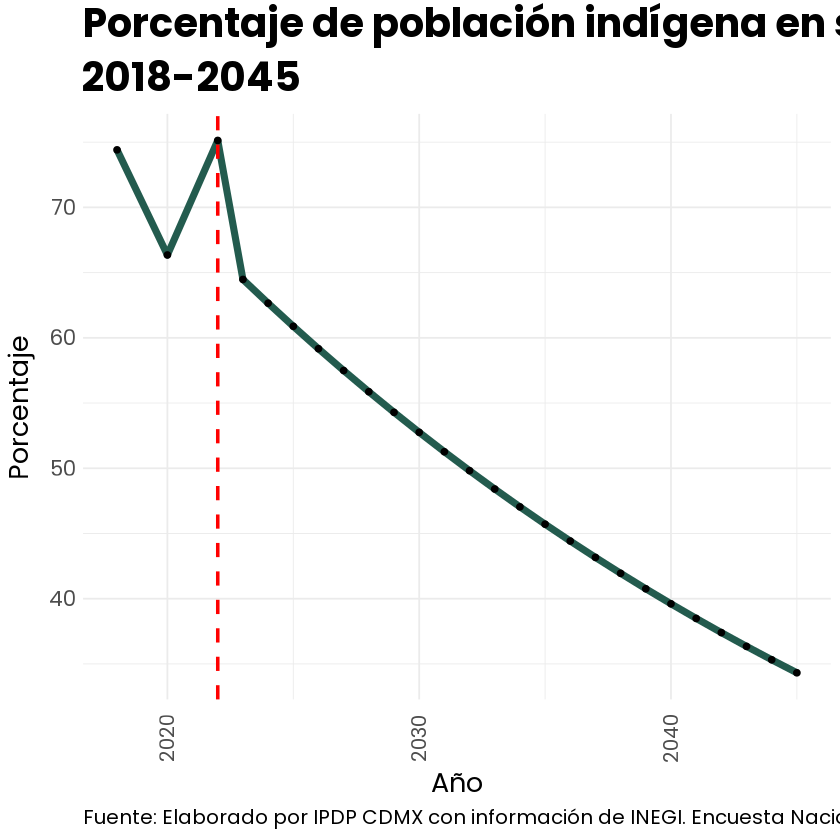

In [28]:
##Calcular tasa de crecimiento promedio anual de 2016 a 2022
valor_inicial<-tabla_pobreza$porcentaje[1]
valor_final <- tabla_pobreza$porcentaje[2]
n <- tabla_pobreza$year[length(tabla_pobreza$year)] - tabla_pobreza$year[1]

tasa_crecimiento_pobreza<- (valor_final / valor_inicial)^(1 / n) - 1
print("Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025")
tasa_crecimiento_pobreza

proyecciones_pobreza <- data.frame(year = seq(2023, 2045, by = 1))
proyecciones_pobreza$porcentaje <- valor_final * (1 + tasa_crecimiento_pobreza)^(proyecciones_pobreza$year - 2022)
proyecciones_pobreza

datos_proyectados_pobreza <- rbind(tabla_pobreza, proyecciones_pobreza)%>%
  select(year,porcentaje)

#Gráfica
ggplot(datos_proyectados_pobreza, aes(x = year, y = porcentaje)) +
  geom_line(color="#235B4E", size=2)+
  geom_point() +
  geom_vline(xintercept = 2022, linetype = "dashed", color = "red", size = 1)+
  labs(title = "Porcentaje de población indígena en situación en pobreza en la CDMX,
2018-2045",
       x = "Año",
       y = "Porcentaje",

       caption="Fuente: Elaborado por IPDP CDMX con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)."
       ) +

  theme_minimal()+
  theme(
    plot.title = element_text(hjust = 0, size=30,face="bold"),
    plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
    plot.caption = element_text(hjust = 0,size=15),
    axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
    text=element_text("pop",size=20))

ggsave("pob_pobreza_ind.png",width=16,height=8, dpi=100, bg="white")



#Datos 2030, 2035 y 2045
datos_proyectados_pobreza %>% filter(year %in% c(2030, 2035, 2045))

*Porcentaje de población que habla alguna  lengua indígena en la CDMX*

In [29]:
#Tabla de Población hablante de lengua indígena en la CDMX
hablante<-data.frame(tabla_hablante$year,tabla_hablante$porcentaje)%>%
  rename(year=tabla_hablante.year,
         porcentaje=tabla_hablante.porcentaje)%>%
  mutate(year=as.numeric(year))
hablante

year,porcentaje
<dbl>,<dbl>
2016,1.41
2018,1.38
2020,1.67
2022,1.43


In [30]:
valor_inicial_hablante<-hablante$porcentaje[1]
valor_final_hablante <- hablante$porcentaje[length(hablante$porcentaje)]
n <- hablante$year[length(hablante$year)] - hablante$year[1]

tasa_crecimiento_hablante <- (valor_final_hablante / valor_inicial_hablante)^(1 / n) - 1
print("Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025")
tasa_crecimiento_hablante

[1] "Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025"


[1] 0.002350214

In [31]:
proyecciones_hablante <- data.frame(year = seq(2023, 2045, by = 1))
proyecciones_hablante$porcentaje <- valor_final_hablante * (1 + tasa_crecimiento_hablante)^(proyecciones_hablante$year - 2022)
proyecciones_hablante

datos_proyectados_hablante <- rbind(hablante, proyecciones_hablante)

year,porcentaje
<dbl>,<dbl>
2023,1.433361
2024,1.436730
2025,1.440106
2026,1.443491
2027,1.446883
2028,1.450284
2029,1.453692
2030,1.457109
2031,1.460533


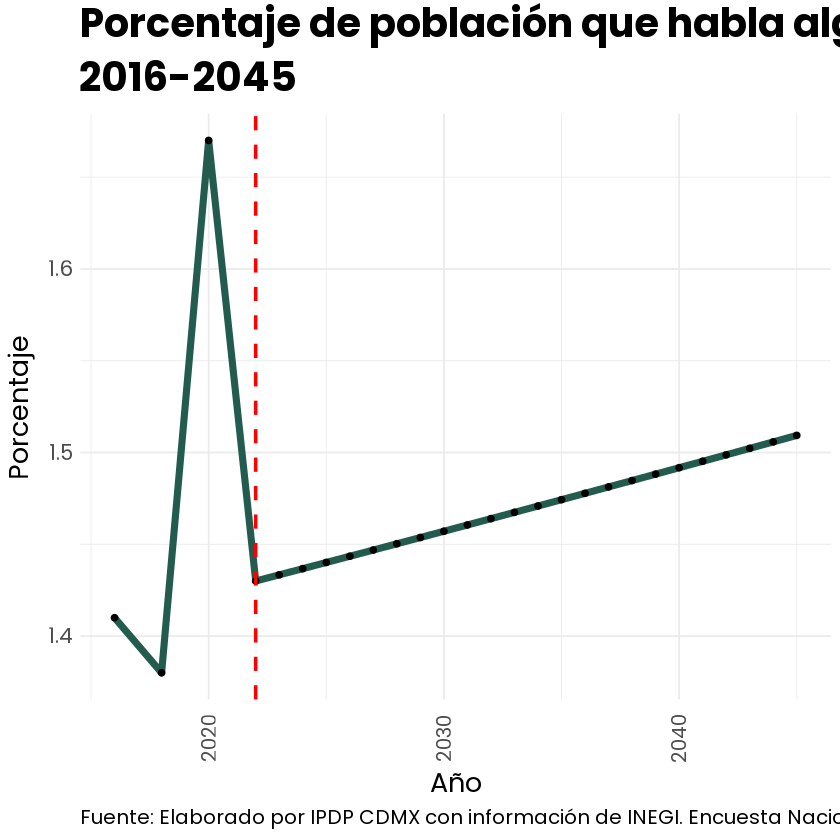

In [32]:
#Gráfica
ggplot(datos_proyectados_hablante, aes(x = year, y = porcentaje)) +
  geom_line(color="#235B4E", size=2)+
  geom_point() +
  geom_vline(xintercept = 2022, linetype = "dashed", color = "red", size = 1)+
  labs(title = "Porcentaje de población que habla alguna  lengua indígena en la CDMX,
2016-2045",
       x = "Año",
       y = "Porcentaje",

       caption="Fuente: Elaborado por IPDP CDMX con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)."
       ) +

  theme_minimal()+
  theme(
    plot.title = element_text(hjust = 0, size=30,face="bold"),
    plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
    plot.caption = element_text(hjust = 0,size=15),
    axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
    text=element_text("pop",size=20))

ggsave("pob_hablante_ind.png",width=16,height=8, dpi=100, bg="white")

*Porcentaje de población que se auto adscribe indígena en la CDMX*

In [33]:
adscribe <- data.frame(tabla_indigena$year, tabla_indigena$porcentaje) %>%
  rename(year = tabla_indigena.year,
         porcentaje = tabla_indigena.porcentaje) %>%
  mutate(year = as.numeric(year))

# Excluir el año 2022 para el cálculo de la tasa de crecimiento
adscribe_sin_2022 <- adscribe %>% filter(year != 2022)

## Calcular tasa de crecimiento promedio anual de 2016 a 2021 (sin incluir 2022)
valor_inicial_adscribe <- adscribe_sin_2022$porcentaje[1]
valor_final_adscribe <- adscribe_sin_2022$porcentaje[length(adscribe_sin_2022$porcentaje)]
n <- adscribe_sin_2022$year[length(adscribe_sin_2022$year)] - adscribe_sin_2022$year[1]

tasa_crecimiento_adscribe <- (valor_final_adscribe / valor_inicial_adscribe)^(1 / n) - 1
print("Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025")
tasa_crecimiento_adscribe

[1] "Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025"


[1] 0.02453971

year,porcentaje
<dbl>,<dbl>
2023,16.17463
2024,16.57155
2025,16.97821
2026,17.39485
2027,17.82171
2028,18.25905
2029,18.70712
2030,19.16619
2031,19.63652


year,porcentaje
<dbl>,<dbl>
2030,19.16619
2035,21.63614
2045,27.57197


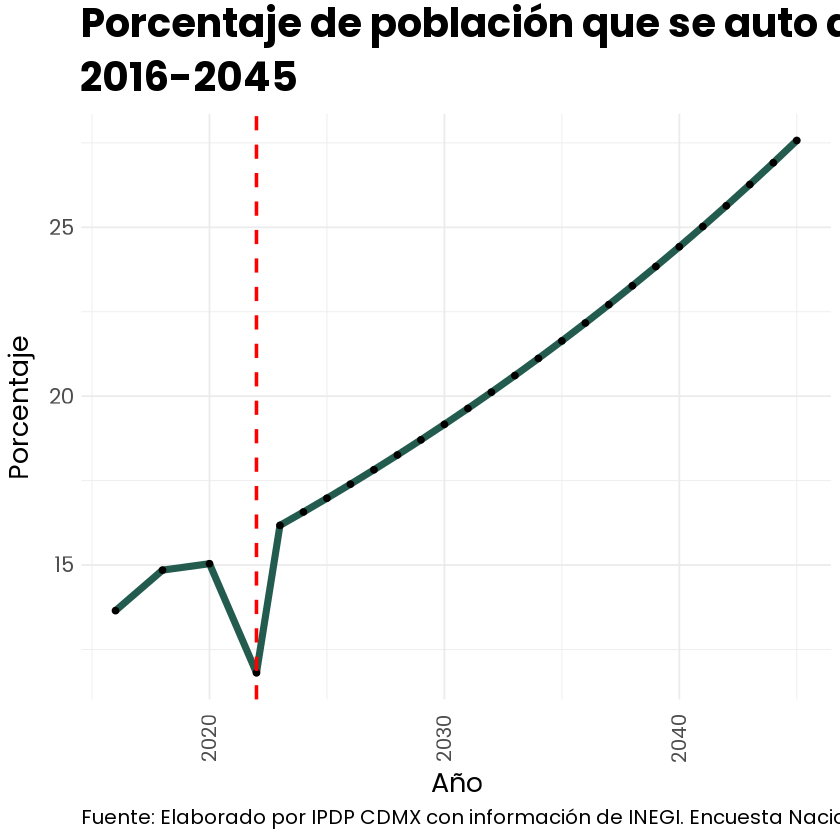

In [34]:
proyecciones_adscribe <- data.frame(year = seq(2023, 2045, by = 1))
proyecciones_adscribe$porcentaje <- valor_final_adscribe * (1 + tasa_crecimiento_adscribe)^(proyecciones_adscribe$year - 2020)
proyecciones_adscribe

datos_proyectados_adscribe <- rbind(adscribe, proyecciones_adscribe)

#Gráfica
ggplot(datos_proyectados_adscribe, aes(x = year, y = porcentaje)) +
  geom_line(color="#235B4E", size=2)+
  geom_point() +
  geom_vline(xintercept = 2022, linetype = "dashed", color = "red", size = 1)+
  labs(title = "Porcentaje de población que se auto adscribe indígena en la CDMX,
2016-2045",
       x = "Año",
       y = "Porcentaje",

       caption="Fuente: Elaborado por IPDP CDMX con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)."
       ) +

  theme_minimal()+
  theme(
    plot.title = element_text(hjust = 0, size=30,face="bold"),
    plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
    plot.caption = element_text(hjust = 0,size=15),
    axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
    text=element_text("pop",size=20))

ggsave("pob_adscribe_ind.png",width=16,height=8, dpi=100, bg="white")



#Datos 2030, 2035 y 2045
datos_proyectados_adscribe %>% filter(year %in% c(2030, 2035, 2045))

*Porcentaje de población ocupada que pertenece a  pueblos indígenas en la CDMX*

In [35]:
ocupada <- data.frame(tabla_ocupacion$year, tabla_ocupacion$porcentaje) %>%
  rename(year = tabla_ocupacion.year,
         porcentaje = tabla_ocupacion.porcentaje) %>%
  mutate(year = as.numeric(year))

# Excluir el año 2022 para el cálculo de la tasa de crecimiento
ocupada_sin_2022 <- ocupada %>% filter(year != 2022)

## Calcular tasa de crecimiento promedio anual de 2016 a 2021 (sin incluir 2022)
valor_inicial_ocupada <- ocupada_sin_2022$porcentaje[1]
valor_final_ocupada <- ocupada_sin_2022$porcentaje[length(ocupada_sin_2022$porcentaje)]
n <- ocupada_sin_2022$year[length(ocupada_sin_2022$year)] - ocupada_sin_2022$year[1]

tasa_crecimiento_ocupada <- (valor_final_ocupada / valor_inicial_ocupada)^(1 / n) - 1
print("Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025")
tasa_crecimiento_ocupada

[1] "Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025"


[1] 0.01648423

year,porcentaje
<dbl>,<dbl>
2023,16.81082
2024,17.08793
2025,17.36961
2026,17.65594
2027,17.94698
2028,18.24282
2029,18.54354
2030,18.84922
2031,19.15993


year,porcentaje
<dbl>,<dbl>
2030,18.84922
2035,20.45486
2045,24.08813


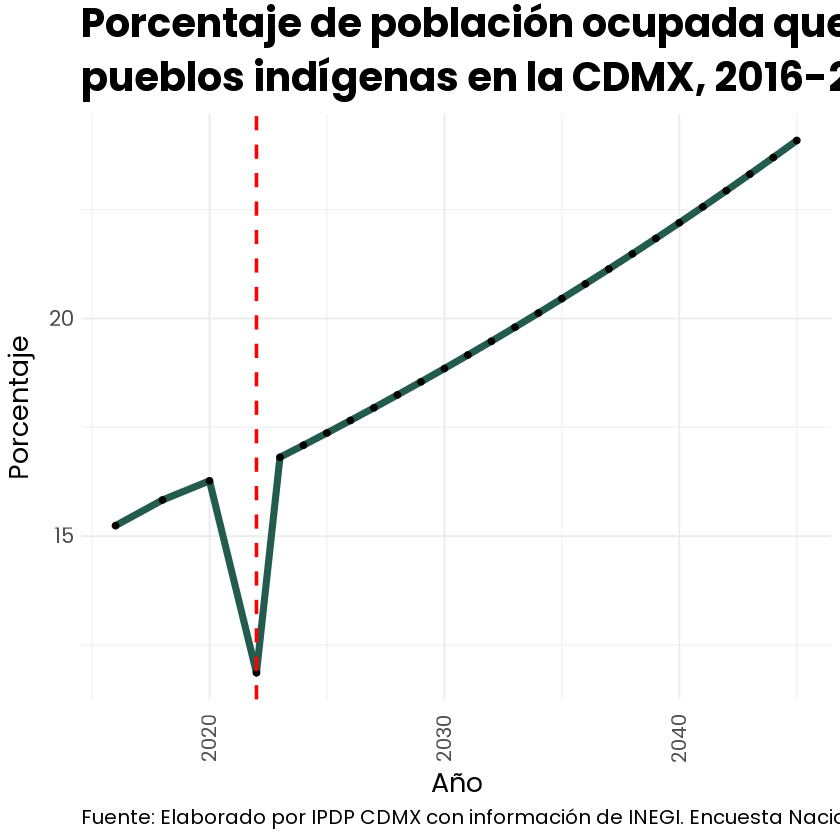

In [36]:
proyecciones_ocupada <- data.frame(year = seq(2023, 2045, by = 1))
proyecciones_ocupada$porcentaje <- valor_final_ocupada * (1 + tasa_crecimiento_ocupada)^(proyecciones_ocupada$year - 2021)
proyecciones_ocupada

datos_proyectados_ocupada <- rbind(ocupada, proyecciones_ocupada)

ggplot(datos_proyectados_ocupada, aes(x = year, y = porcentaje)) +
  geom_line(color="#235B4E", size=2)+
  geom_point() +
  geom_vline(xintercept = 2022, linetype = "dashed", color = "red", size = 1)+
  labs(title = "Porcentaje de población ocupada que pertenece a
pueblos indígenas en la CDMX, 2016-2045",
       x = "Año",
       y = "Porcentaje",

       caption="Fuente: Elaborado por IPDP CDMX con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)."
       ) +

  theme_minimal()+
  theme(
    plot.title = element_text(hjust = 0, size=30,face="bold"),
    plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
    plot.caption = element_text(hjust = 0,size=15),
    axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
    text=element_text("pop",size=20))

ggsave("pob_ocupada_ind.png",width=16,height=8, dpi=100, bg="white")





#Datos 2030, 2035 y 2045
datos_proyectados_ocupada %>% filter(year %in% c(2030, 2035, 2045))

*Porcentaje de población ocupada mujer que pertenece a pueblos indígenas en la Ciudad*

In [37]:
ocupadam <- data.frame(tabla_ocupacion_mujer$year, tabla_ocupacion_mujer$porcentaje) %>%
  rename(year = tabla_ocupacion_mujer.year,
         porcentaje = tabla_ocupacion_mujer.porcentaje) %>%
  mutate(year = as.numeric(year))
# Excluir el año 2022 para el cálculo de la tasa de crecimiento
ocupadam_sin_2022 <- ocupadam %>% filter(year != 2022)
ocupadam_sin_2022

year,porcentaje
<dbl>,<dbl>
2016,43.98
2018,44.89
2020,45.44


In [38]:
valor_inicial_ocupadam <- ocupadam_sin_2022$porcentaje[1]
valor_inicial_ocupadam

[1] 43.98

In [39]:
valor_final_ocupadam <- ocupadam_sin_2022$porcentaje[2]
valor_final_ocupadam

[1] 44.89

In [40]:
#Metas población ocupada mujeres
#Tabla de Población ocupada indígena mujeres en la CDMX
## Calcular tasa de crecimiento promedio anual de 2016 a 2021 (sin incluir 2022)
valor_inicial_ocupadam <- ocupadam_sin_2022$porcentaje[1]
valor_final_ocupadam <- ocupadam_sin_2022$porcentaje[length(ocupadam_sin_2022$porcentaje)]
#valor_final_ocupadam <- ocupadam_sin_2022$porcentaje[3]
n <- 10
#n <- ocupadam_sin_2022$year[length(ocupadam_sin_2022$year)] - ocupadam_sin_2022$year[1]

tasa_crecimiento_ocupadam <- (valor_final_ocupadam / valor_inicial_ocupadam)^(1 / n) - 1
print("Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025")
tasa_crecimiento_ocupadam

[1] "Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025"


[1] 0.003271117

year,porcentaje
<dbl>,<dbl>
2023,45.73777
2024,45.88738
2025,46.03748
2026,46.18808
2027,46.33916
2028,46.49074
2029,46.64282
2030,46.79539
2031,46.94847


year,porcentaje
<dbl>,<dbl>
2030,46.79539
2035,47.56578
2045,49.14482


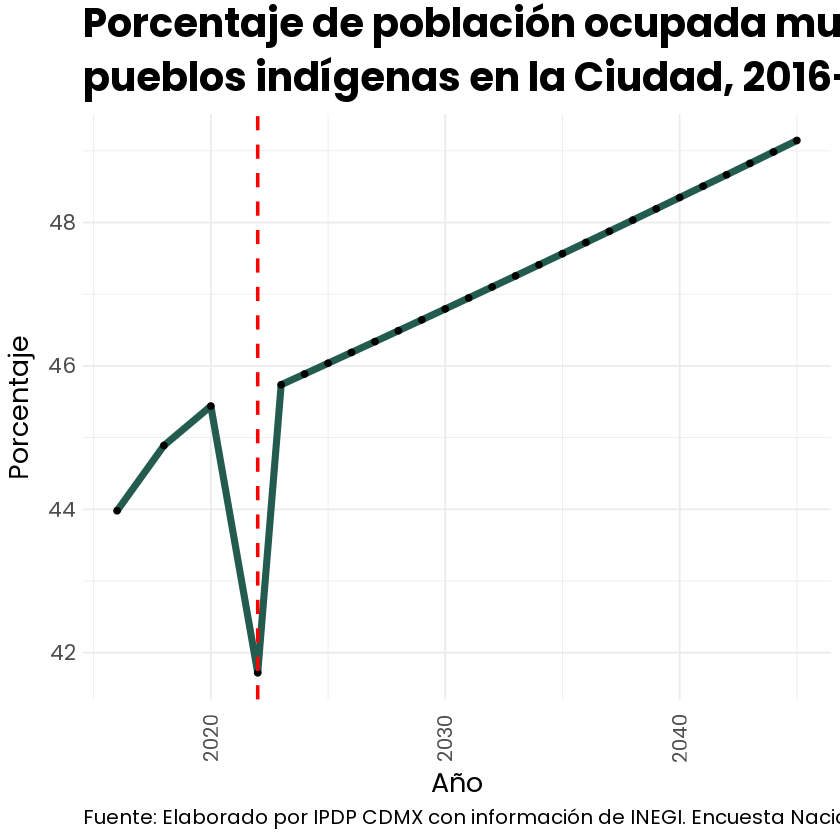

In [41]:
proyecciones_ocupadam <- data.frame(year = seq(2023, 2045, by = 1))
proyecciones_ocupadam$porcentaje <- valor_final_ocupadam * (1 + tasa_crecimiento_ocupadam)^(proyecciones_ocupadam$year - 2021)
proyecciones_ocupadam

datos_proyectados_ocupadam <- rbind(ocupadam, proyecciones_ocupadam)


ggplot(datos_proyectados_ocupadam, aes(x = year, y = porcentaje)) +
  geom_line(color="#235B4E", size=2)+
  geom_point() +
  geom_vline(xintercept = 2022, linetype = "dashed", color = "red", size = 1)+
  labs(title = "Porcentaje de población ocupada mujer que pertenece a
pueblos indígenas en la Ciudad, 2016-2045",
       x = "Año",
       y = "Porcentaje",

       caption="Fuente: Elaborado por IPDP CDMX con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)."
       ) +

  theme_minimal()+
  theme(
    plot.title = element_text(hjust = 0, size=30,face="bold"),
    plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
    plot.caption = element_text(hjust = 0,size=15),
    axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
    text=element_text("pop",size=20))

ggsave("pob_ocupada_mujer_ind.png",width=16,height=8, dpi=100, bg="white")



#Datos 2030, 2035 y 2045
datos_proyectados_ocupadam %>% filter(year %in% c(2030, 2035, 2045))

### Escenarios

In [43]:
generar_grafica <- function(tabla_obs, tabla_est, margen, titulo,
                            nombre_archivo, nombre_estimado_futuro,
                            linea_vertical,
                            ano_base= 2022,
                            nombre_intervalo_superior, nombre_intervalo_inferior,
                            limite_inferior_y, variable_intervals = "porcentaje") {

  serie_completa <- dplyr::bind_rows(
    tabla_obs %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(variable_intervals, margen = 0, año_base = ano_base),

    tabla_est %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(variable_intervals, margen = margen, año_base = ano_base)
  )

  grafica <- grafica_bonita(
    data = serie_completa,
    x = "year",
    y = "estimado",
    titulo = titulo,
    linea_vertical = linea_vertical,
    mostrar_intervalo = "ambos",
    nombre_observado = "Observado",
    nombre_estimado_futuro = nombre_estimado_futuro,
    nombre_intervalo_superior = nombre_intervalo_superior,
    nombre_intervalo_inferior = nombre_intervalo_inferior,
    mostrar_leyenda = TRUE,
    fuente = "pop",
    etiqueta_x = "Año",
    etiqueta_y = "Porcentaje",
    titulo_leyenda = "Escenarios",
    limite_inferior_y = limite_inferior_y
  )

  ggplot2::ggsave(nombre_archivo, grafica, width = 12, height = 10, dpi = 100, bg = "white")}

In [47]:
configuraciones <- tibble::tibble(
  tabla_obs = list(tabla_hablante,tabla_indigena,tabla_ocupacion,tabla_ocupacion_mujer,tabla_analfabetismo,tabla_pobreza),
  tabla_est = list(proyecciones_hablante,proyecciones_adscribe,proyecciones_ocupada,proyecciones_ocupadam,proyecciones,proyecciones_pobreza),
  margen = c(0.004,0.004,0.004,0.004,0.004,0.004),
  ano_base = c(2019,2020,2020,2020,2020,2020),
  nombre_archivo = c("habla_indigena_estimada.png",
  "autoadscribe_indigena_estimada.png",
  "ocupada_indigena_estimada.png",
  "mujeres_ocup_indigena_estimada.png",
  "analfabeta_indigena_estimada.png",
  "indigena_pobreza_estimada.png"),
  linea_vertical = c(2022, 2022, 2022,2022,2022,2022),
  titulo = c("Porcentaje de población
  que habla alguna lengua indígena en la CDMX",
  "Porcentaje de población
  que se auto adscribe indígena en la CDMX",
  "Porcentaje de población ocupada
  que pertenece a  pueblos indígenas en la CDMX",
  "Porcentaje de mujeres indígenas ocupadas
  en la Ciudad de México",
  "Porcentaje de población analfabeta indígena
  en la CDMX",
  "Porcentaje de población indígena
  en situación de pobreza en la CDMX"
  ),
  nombre_estimado_futuro = c("Deseable", "Deseable", "Deseable","Deseable","Deseable","Deseable"),
  nombre_intervalo_superior = c("Transformador", "Transformador", "Transformador","Transformador","Transformador","Inercial"),
  nombre_intervalo_inferior = c("Inercial","Inercial","Inercial","Inercial","Inercial","Transformador"),
  limite_inferior_y = c(0,0,0,0,0,0),
  variable_intervals = c("porcentaje","porcentaje","porcentaje","porcentaje","porcentaje","porcentaje")
)

In [48]:
pmap(
  configuraciones,
  function(tabla_obs, tabla_est, margen,
  nombre_archivo,linea_vertical,ano_base,
           titulo, nombre_estimado_futuro,
           nombre_intervalo_superior, nombre_intervalo_inferior,
           limite_inferior_y, variable_intervals) {
    generar_grafica(
      tabla_obs = tabla_obs,
      tabla_est = tabla_est,
      ano_base = ano_base,
      linea_vertical = linea_vertical,
      margen = margen,
      titulo = titulo,
      nombre_archivo = nombre_archivo,
      nombre_estimado_futuro = nombre_estimado_futuro,
      nombre_intervalo_superior = nombre_intervalo_superior,
      nombre_intervalo_inferior = nombre_intervalo_inferior,
      limite_inferior_y = limite_inferior_y,
      variable_intervals = variable_intervals
    )
  }
)

Adding missing grouping variables: `trapais`
Adding missing grouping variables: `etnia`
Adding missing grouping variables: `etnia`
Adding missing grouping variables: `etnia`


[[1]]
[1] "habla_indigena_estimada.png"

[[2]]
[1] "autoadscribe_indigena_estimada.png"

[[3]]
[1] "ocupada_indigena_estimada.png"

[[4]]
[1] "mujeres_ocup_indigena_estimada.png"

[[5]]
[1] "analfabeta_indigena_estimada.png"

[[6]]
[1] "indigena_pobreza.png"

# Nueva sección